# The Daubechies D4 Wavelet Tranform

##### All functions and variables declaration

In [59]:
import numpy as np
import cv2
import IPython
from PIL import Image
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from time import time

def split_matrix(mat): # divide the matrix into 4 quadrants
    h, w = mat.shape
    return mat[:h // 2, :w // 2], mat[:h // 2, w // 2:], mat[h // 2:, :w // 2], mat[h // 2:, w // 2:]

def concatenate_matrices(m1, m2, m3, m4):
    return np.concatenate((np.concatenate((m1, m2), axis=1),
                            np.concatenate((m3, m4), axis=1)), axis=0)

def imshow(image, width=None):
    _, ret = cv2.imencode('.jpg', image)
    i = IPython.display.Image(data=ret, width=width)
    IPython.display.display(i)

def jpg_to_pgm(jpg_path):
    image = Image.open(jpg_path)
    image_gray = image.convert('L')
    width = image_gray.size[0]
    if (width>512):
        image_gray = image_gray.resize((512, 512))
        pixels = list(image_gray.getdata())

    else: pixels = list(image_gray.getdata())

    return np.array(pixels).reshape((512, 512))

def new_p(matrix):
    max,min  = np.max(matrix), np.min(matrix)
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            matrix[i][j] = ((matrix[i][j]-min)*255.0)/(max-min)
    return matrix

###############################
# def function_daubechies_coeffs(image,h_coeffs,g_coeffs):
#     rows, cols = image.shape
#     matrix_coeffs = np.zeros((rows, cols))

#     for i in range(rows // 2):
#         if i < rows // 2 - 1: 
#             matrix_coeffs[i, 2 * i:2 * i + h_coeffs.shape[0]] = h_coeffs
            
#             matrix_coeffs[i + rows // 2, 2 * i:2 * i + g_coeffs.shape[0]] = g_coeffs
#         else:
#             matrix_coeffs[i, 2 * i:2 * i + 2] = h_coeffs[:2]
#             matrix_coeffs[i, 0:2] = h_coeffs[2:]

#             matrix_coeffs[i + rows // 2, 2 * i:2 * i + 2] = g_coeffs[:2]
#             matrix_coeffs[i + rows // 2, 0:2] = g_coeffs[2:]
            
#     # return csr_matrix(matrix_coeffs)
#     return np.round(matrix_coeffs,2)
###############################
# def function_daubechies_coeffs(image,h_coeffs,g_coeffs):
#     rows, cols = image.shape
#     matrix_coeffs = np.zeros((rows, cols))

#     for i in range(rows // 2):
#         if i < rows // 2 - 1: 
#             matrix_coeffs[i, 2 * i:2 * i + h_coeffs.shape[0]] = h_coeffs
            
#             matrix_coeffs[i + rows // 2, 2 * i:2 * i + h_coeffs.shape[0]] = g_coeffs
#         else:
#             matrix_coeffs[i, 2 * i:2 * i + 2] = h_coeffs[:2]
#             matrix_coeffs[i, 0:2] = h_coeffs[22:]
# z
#             matrix_coeffs[i + rows // 2, 2 * i:2 * i + rows // 2] = g_coeffs[:rows // 2]
#             matrix_coeffs[i + rows // 2, 0:rows // 2] = g_coeffs[rows // 2:]
            
#     # return csr_matrix(matrix_coeffs)
#     return np.round(matrix_coeffs,2)


     
root2, root3 = np.sqrt(2), np.sqrt(3) 

h_coeffs = np.array([(1 + root3) / (4 * root2),
                     (3 + root3) / (4 * root2),
                     (3 - root3) / (4 * root2),
                     (1 - root3) / (4 * root2)
                     ])

g_coeffs = np.array([h_coeffs[3], 
                    -h_coeffs[2],
                     h_coeffs[1], 
                    -h_coeffs[0]])


# h0 = 0.1601023979741929
# h1 = 0.6038292697971895
# h2 = 0.7243085284377729
# h3 = 0.1384281459013203
# h4 = -0.2422948870663824
# h5 = -0.0322448695846381
# h6 = 0.0775714938400459
# h7 = -0.0062414902127983
# h8 = -0.0125807519990810
# h9 = 0.0033357252854738

# g0 = 0.0033357252854738
# g1 = 0.0125807519990810
# g2 = -0.0062414902127983
# g3 = -0.0775714938400459
# g4 = -0.0322448695846381
# g5 = 0.2422948870663824
# g6 = 0.1384281459013203
# g7 = -0.7243085284377729
# g8 = 0.6038292697971895
# g9 = -0.1601023979741929

# h_coeffs = np.array([h0,h1,h2,h3,h4,h5,h6,h7,h8,h9])

# g_coeffs = np.array([g0,g1,g2,g3,g4,g5,g6,g7,g8,g9])


##### Prueba

In [60]:
################################
def function_daubechies_coeffs(image,h_coeffs,g_coeffs):
    coeffs_h, coeffs_g, matrix_coeffs = h_coeffs.copy(), g_coeffs.copy(), np.zeros(image.shape)

    zeros_array = np.zeros(abs(matrix_coeffs.shape[0]-coeffs_h.shape[0]))
    if matrix_coeffs.shape[0]>coeffs_h.shape[0]:
        coeffs_h = np.append(coeffs_h, zeros_array)
        coeffs_g = np.append(coeffs_g, zeros_array)
    else: 
        coeffs_h = coeffs_h[:-zeros_array.shape[0]]
        coeffs_g = coeffs_g[:-zeros_array.shape[0]]

    for i in range(matrix_coeffs.shape[0]):
        if i < matrix_coeffs.shape[0]//2:
            matrix_coeffs[i,:] = np.roll(coeffs_h,i*2)
        else: 
            matrix_coeffs[i,:] = np.roll(coeffs_g,i*2)

    # return csr_matrix(matrix_coeffs)
    return np.round(matrix_coeffs,2)

################################

##### Daubechies Functions

In [61]:
def daubechies4_wavelet_transform_2D(daubechies_coeffs,image,scale,width, details = None):
    result_H = []

    for row in image: #ESTA PARTE HACE LA HORIZONTAL
        result_H.append(daubechies_coeffs.dot(row))
    result_V = daubechies_coeffs.dot(result_H)

    if scale == 1:
        normalized = result_V.copy()
        aP,cH,cV,cD = split_matrix(normalized)
        normalized = concatenate_matrices(new_p(aP),new_p(cH),new_p(cV),new_p(cD))
        if details is not None:
            for i in range(len(details)//3):
                result_V = concatenate_matrices(result_V,details[0+(i*3)],details[1+(i*3)],details[2+(i*3)])
                normalized = concatenate_matrices(new_p(normalized),new_p(details[0+(i*3)]),new_p(details[1+(i*3)]),new_p(details[2+(i*3)])) ########
  
            return result_V, normalized
        else:
            return result_V, normalized
        
    elif (np.log2(width//4) >= scale > 1):
        aP,cH,cV,cD = split_matrix(result_V)
        details = ([cH,cV,cD] + details) if details is not None else [cH,cV,cD]
        return daubechies4_wavelet_transform_2D(function_daubechies_coeffs(aP,h_coeffs,g_coeffs),aP,scale-1,aP.shape[0],details)

    else : print(f"Error. The scale value has to be between 1 - {int(np.log2(width//4))}")
    return np.ones_like(image), np.ones_like(image)


def inverse_daubechies4_wavelet_transform_2D(daubechies_coeffs, transform_result,scale,width):
    new_transform = transform_result.copy()
    image = []
    
    if scale == 1:
        daubechies_coeffs_transpose = daubechies_coeffs.T
        
        result_H = daubechies_coeffs_transpose.dot(transform_result)
        for row in result_H:
            original_row = daubechies_coeffs_transpose.dot(row)
            image.append(original_row)
            
        return np.array(image)
    
    else: 
        tam_img = width // (2 ** scale) * 2
        aP = new_transform[:tam_img, :tam_img]
        daubechies_coeffs_transpose = function_daubechies_coeffs(aP,h_coeffs,g_coeffs).T
        
        result_H = daubechies_coeffs_transpose.dot(aP)
        for row in result_H:
            original_row = daubechies_coeffs_transpose.dot(row)
            image.append(original_row)

        new_transform[:len(image), :len(image)] = image

        return inverse_daubechies4_wavelet_transform_2D(function_daubechies_coeffs(new_transform,h_coeffs,g_coeffs),new_transform,scale-1,new_transform.shape[0])

In [62]:
def zeros(image, scale):
    tam_img = image.shape[0] // (2 ** scale)
    image[:tam_img, :tam_img] = np.zeros((tam_img, tam_img))
    print(tam_img)
    return image

##### Checking Orthonormality

In [63]:
def verificar_ortonormalidad(v1, v2):
    if len(v1) != len(v2):
        print("The vectors are not similar, they are not orthonormal")

    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    
    if np.isclose(dot_product, 0) and np.isclose(norm_v1, 1) and np.isclose(norm_v2, 1):
        print(f"The vectors are orthonormal, the dot product is: {dot_product} and the norm of each vector is {norm_v1, norm_v2} respectively")
    else:
        print("The vectors are similar but they are not orthonormal")
    
verificar_ortonormalidad(h_coeffs, g_coeffs)

The vectors are orthonormal, the dot product is: 0.0 and the norm of each vector is (0.9999999999999998, 0.9999999999999998) respectively


## NUMERIC EXAMPLE

In [64]:
example = np.random.randint(0.0, 52.0, (12, 12))
# example_daubechies_4 = function_daubechies_coeffs(example)
example_daubechies_4 = function_daubechies_coeffs(example,h_coeffs,g_coeffs)
# example_daubechies_4_transposed = example_daubechies_4.T
print(f"\nCoeffs Matrix:\n {example_daubechies_4}")
# print(f"\nCoeffs Matrix Transposed:\n {example_daubechies_4_transposed}")



Coeffs Matrix:
 [[ 0.48  0.84  0.22 -0.13  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.48  0.84  0.22 -0.13  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.48  0.84  0.22 -0.13  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.48  0.84  0.22 -0.13  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.48  0.84  0.22 -0.13]
 [ 0.22 -0.13  0.    0.    0.    0.    0.    0.    0.    0.    0.48  0.84]
 [-0.13 -0.22  0.84 -0.48  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.   -0.13 -0.22  0.84 -0.48  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -0.13 -0.22  0.84 -0.48  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.   -0.13 -0.22  0.84 -0.48  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.   -0.13 -0.22  0.84 -0.48]
 [ 0.84 -0.48  0.    0.    0.    0.    0.    0.    0.    0.   -0.13 -0.22]]

Coeffs Matrix Transposed:
 [[ 0.48  0.    0.    0.    0.    0.22 -0.13  0.    0. 

In [65]:
aP,cH,cV,cD = split_matrix(example)
scale = 1
dwt, normal = daubechies4_wavelet_transform_2D(example_daubechies_4,example,scale,example.shape[0])
idwt = inverse_daubechies4_wavelet_transform_2D(example_daubechies_4,dwt,scale,dwt.shape[0])

print(f"Original Matrix:\n {example}")
print(f"\nDirect daubechies Wavelet Transform\n {np.round(dwt,0)}")
print(f"\nInverse daubechies Wavelet Transform\n {np.round((idwt),0)}")

Original Matrix:
 [[40 36 21 32 30  4 15 51 32  2 25 37]
 [33 30 22  0 34  8  7 43 26 47 32 37]
 [ 6  3 28 34 31 50 19  3 14 11  7  3]
 [15  3 28 33 27 14 34  1 36 37  7  1]
 [ 2 35 45 51 41 20 38 35 31 20 11 22]
 [33 21 30 23  0 11 13  4 45 36 20 25]
 [48 26 25 21 15 23  8 17 46 27 40  3]
 [24 20 29 31  9 20 27 11 36 20  0 37]
 [31  8 17  1 31 30 49 24 19 48 38 48]
 [ 3  5 18 44 17  1 30 49 12 37 38 34]
 [14 12  4 14 19  4 46 39 27  3 32 17]
 [ 0  1  3  2 31 30 46 35 39 12 18 42]]

Direct daubechies Wavelet Transform
 [[ 63.  38.  32.  60.  51.  65.   2.  22. -28.  -3.  -4.   2.]
 [ 16.  70.  63.  33.  50.   9.   8.   3.  18.   7.  -7.   3.]
 [ 54.  63.  31.  39.  67.  41.   6.  -8.   5.  20.  -4.   2.]
 [ 54.  44.  43.  37.  56.  50.   4. -12.  10.  21. -15.  16.]
 [ 19.  50.  29.  71.  60.  71.  -4.   7.  11. -28.   8.  -6.]
 [ 14.  21.  47.  86.  30.  56.  -6.  14.  16.  19.  -3. -10.]
 [-16.   4.  30. -15. -24. -15.   2. -17.  -4.  -0.   5.  -4.]
 [  7.  29.  13.  30. -12.  -3.   

## IMAGES EXAMPLES

In [66]:
photo = 'imagen.jpg'

8
1.0055453777313232


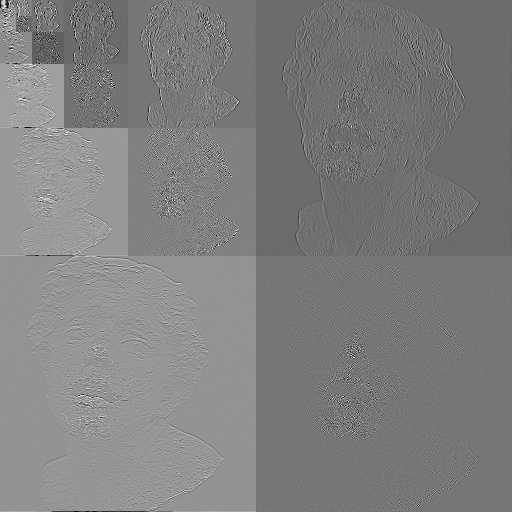

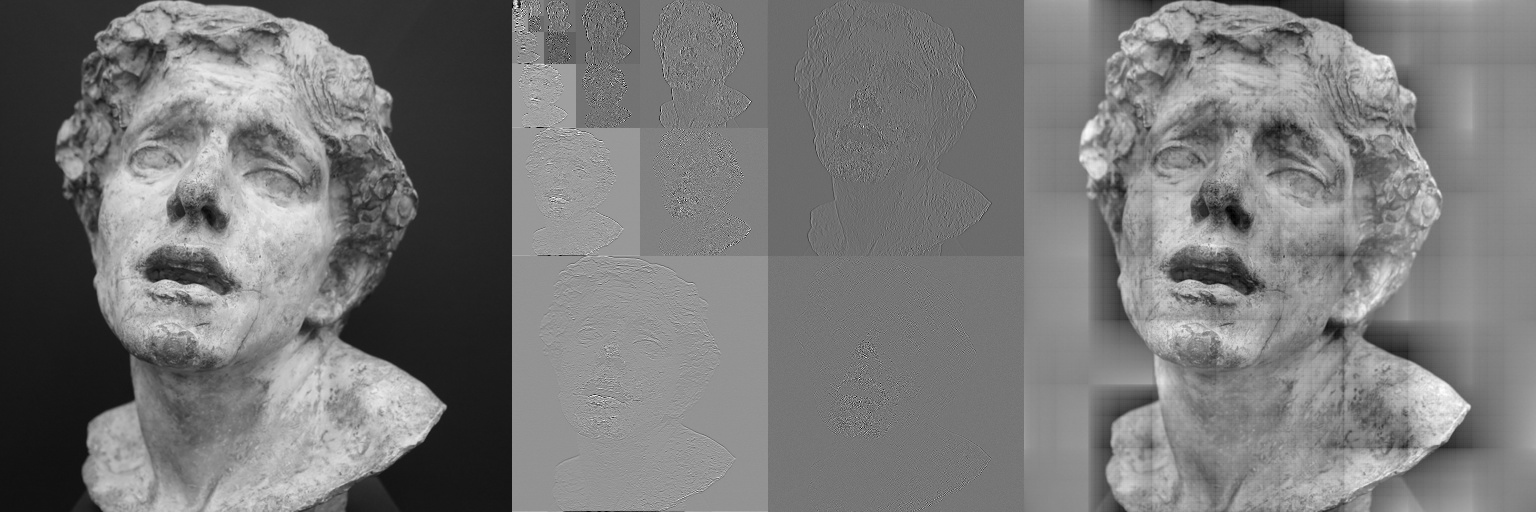

In [67]:
initial_time = time() 
array_photo = jpg_to_pgm(photo)
daubechies_4 = function_daubechies_coeffs(array_photo,h_coeffs,g_coeffs)
scale, width = 6, array_photo.shape[0]
result_img, normalized = daubechies4_wavelet_transform_2D(daubechies_4,array_photo,scale,width)
result_img = zeros(result_img, scale)


reconstructed = inverse_daubechies4_wavelet_transform_2D(daubechies_4,result_img,scale,width)
final_time = time()


execution_time = final_time - initial_time
print(execution_time)
imshow(normalized)
print()
imshow(np.concatenate((array_photo, normalized, new_p(reconstructed)), axis = 1))